### Train a Spiky Neural Network with Heidelberg Digits Dataset
Uses more sophistocated cochlear model to generate spike data corresponding to audio recordings of spoken digits

In [1]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils import data

from utils import get_shd_dataset

In [2]:
# The coarse network structure and the time steps are dictated by the SHD dataset
nb_inputs = 700
nb_hidden = 200
nb_outputs = 20

time_step = 1e-3
nb_steps = 100
max_time = 1.4

batch_size = 256

In [3]:
dtype = float
device = torch.device("cpu")

Setup of the spiking dataset

In [4]:
cache_dir = os.path.expanduser("./datasets")
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

train_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_train.h5'), 'r')
test_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_test.h5'), 'r')

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = train_file['spikes']
y_test = train_file['labels']

Available at: ./datasets/hdspikes/shd_train.h5
Available at: ./datasets/hdspikes/shd_test.h5


In [5]:
# def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
#     labels_ = np.array(y, dtype=int)
#     number_of_batches = len(labels_)//batch_size
#     sample_index = np.arange(len(labels_))
    
#     # compute discrete firing times
#     firing_times = X['times']
#     units_fired = X['units']
    
#     time_bins = np.linspace(0, max_time, num=nb_steps)
    
#     if shuffle:
#         np.random.shuffle(sample_index)
        
#     total_batch_count = 0
#     counter = 0
#     while counter<number_of_batches:
#         batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        
#         coo = [[] for i in range(3)]
        
#         for bc,idx in enumerate(batch_index):
#             times = np.digitize(firing_times[idx], time_bins)
#             units = units_fired[idx]
#             batch = [bc for _ in range(len(times))]
            
#             coo[0].extend(batch)
#             coo[1].extend(times)
#             coo[2].extend(units)
        
#     i = torch.LongTensor(coo).to(device)
#     v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
#     X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps, nb_units])).to(device)
#     y_batch = torch.tensor(labels_[batch_index], device=device)
    
#     yield X_batch.to(device=device), y_batch.to(device=device)
    
#     counter += 1
def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    """ This generator takes a spike dataset and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=int)
    number_of_batches = len(labels_)//batch_size
    sample_index = np.arange(len(labels_))

    # compute discrete firing times
    firing_times = X['times']
    units_fired = X['units']
    
    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            batch = [bc for _ in range(len(times))]
            
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1
        

Setup of the spiking network model

In [6]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

Include recurrent weights in the hidden layer

In [47]:
weight_scale = 0.2

w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [18]:
def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5):
    gs = GridSpec(*dim)
    if spk is not None:
        dat = 1.0 * mem
        dat[spk > 0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i == 0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i], sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [19]:
from IPython.display import clear_output

def live_plot(loss):
    if len(loss) == 1:
        return
    clear_output(wait=True)
    ax = plt.figure(figsize=(3, 2), dpi=150).gca()
    ax.plot(range(1, len(loss) + 1), loss)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.xaxis.get_major_locator().set_params(integer=True)
    sns.despine()
    plt.show()

#### Training the Network

In [20]:
class SurrGradSpike(torch.autograd.Function):
    scale = 100.0
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input / (SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
spike_fn = SurrGradSpike.apply

In [55]:
def run_snn(inputs):
    syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    
    mem_rec = []
    spk_rec = []
    
    out = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs.double(), w1))
    for t in range(nb_steps):
        h1 = h1_from_input[:, t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach()
        
        new_syn = alpha*syn + h1
        new_mem = (beta*mem + syn)*(1.0-rst)
        
        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn
        
    mem_rec = torch.stack(mem_rec, dim = 1)
    spk_rec = torch.stack(spk_rec, dim = 1)
    
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size, nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt + h2[:, t]
        new_out = beta * out + flt
        
        flt = new_flt
        out = new_out
        
        out_rec.append(out)
        
    out_rec = torch.stack(out_rec, dim=1)
    other_recs = [mem_rec, spk_rec]
    
    return out_rec, other_recs

In [51]:
def train(x_data, y_data, lr=1e-3, nb_epochs=10):
    params = [w1, w2, v1]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9, 0.999))
    
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time):
            output, recs = run_snn(x_local.to_dense())
            _, spks = recs
            m, _ = torch.max(output, 1)
            log_p_y = log_softmax_fn(m)
            
            reg_loss = 2e-6*torch.sum(spks)
            reg_loss += 2e-6*torch.mean(torch.sum(torch.sum(spks, dim=0), dim=0)**2)
            
            loss_val = loss_fn(log_p_y, y_local) + reg_loss
            
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        live_plot(loss_hist)
        print("Epoch %i: loss=%.5f"%(e+1, mean_loss))
        
    return loss_hist

def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [57]:
nb_epochs = 200

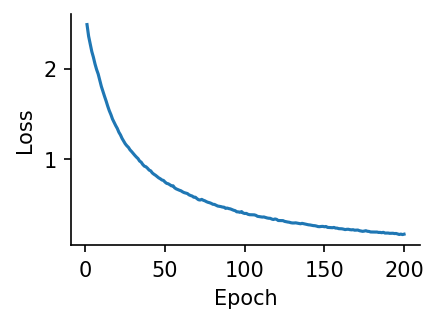

Epoch 200: loss=0.16924


In [58]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=nb_epochs)